## Introducción

## Etapa I - Reconocimiento Facial

### Instalar dependencias


Descargamos y descomprimos un archivo de datos de puntos de referencia faciales (face landmarks) desde la web.
El archivo descargado es el modelo shape_predictor_68_face_landmarks.dat, que se utiliza para localizar puntos clave en rostros (como ojos, nariz, boca, etc.) y es esencial para tareas de reconocimiento y alineación facial en aplicaciones de visión por computadora.

In [ ]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()

    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

!pip install tensorflow
!pip install --upgrade tensorflow



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Definimos funciones de ayuda para la construccion del modelo

Este código define una serie de funciones y constantes en TensorFlow y NumPy para construir y cargar pesos en una red neuronal profunda, en una red tipo Inception paraposteriormente ser utlizado en la creacion del modelo.

Se definen variables y funciones básicas

In [ ]:
import tensorflow as tf
import numpy as np
import os

from numpy import genfromtxt
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, BatchNormalization

_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
  v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
  _get_session().run(v.initializer)
  return v

def shape(x):
  return x.get_shape()

def square(x):
  return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
  return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
  if axis < 0:
      axis = axis % len(tensors[0].get_shape())
  return tf.concat(axis, tensors)

Definimos la normalización de respuesta local o LRN2D (Local Response Normalization en 2 dimensiones).

Es una técnica que utilizamos en la red neuronal para mejorar el rendimiento y precisión. Funciona destacando características más fuertes y reduciendo la influencia de características menos destacadas. Esta normalización compara cada activación en la capa con las activaciones vecinas y ajusta su valor en función de las activaciones circundantes.

In [ ]:
def LRN2D(x):
  return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

Definimos una función conv2d_bn.

La función conv2d_bn aplica una combinación de capas a una entrada x, realiza convoluciones, normalización por lotes y activación (ReLU), y opcionalmente aplica relleno (padding) en la entrada.

In [ ]:
def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
  num = '' if cv2_out == None else '1'
  tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
  tensor = Activation('relu')(tensor)
  if padding == None:
    return tensor
  tensor = ZeroPadding2D(padding=padding)(tensor)
  if cv2_out == None:
    return tensor
  tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
  tensor = Activation('relu')(tensor)
  return tensor

Cargamos pesos de capas convolucionales, capas de normalización por lotes y una capa densa, y los organizamos en un diccionario de Python para su uso posterior en el modelo.

In [ ]:
weights = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights():
  weightsDir = './weights'
  fileNames = filter(lambda f: not f.startswith('.'), os.listdir(weightsDir))
  paths = {}
  weights_dict = {}

  for n in fileNames:
    paths[n.replace('.csv', '')] = weightsDir + '/' + n

  for name in weights:
    if 'conv' in name:
      conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      conv_w = np.reshape(conv_w, conv_shape[name])
      conv_w = np.transpose(conv_w, (2, 3, 1, 0))
      conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      weights_dict[name] = [conv_w, conv_b]
    elif 'bn' in name:
      bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
      bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
      weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
    elif 'dense' in name:
      dense_w = genfromtxt(weightsDir+'/dense_w.csv', delimiter=',', dtype=None)
      dense_w = np.reshape(dense_w, (128, 736))
      dense_w = np.transpose(dense_w, (1, 0))
      dense_b = genfromtxt(weightsDir+'/dense_b.csv', delimiter=',', dtype=None)
      weights_dict[name] = [dense_w, dense_b]

  return weights_dict

### Arquitectura del modelo

La arquitectura de la CNN utilizada es una variante de la arquitectura Inception. Más precisamente, es una variante de la arquitectura NN4 e identificada como el modelo nn4.small2 en el proyecto OpenFace. Este notebook utiliza una implementación en Keras de ese modelo, cuya definición se tomó del proyecto Keras-OpenFace.

Los detalles de la arquitectura no son demasiado importantes para nuestro caso, solo es útil saber que hay una capa completamente conectada con 128 unidades ocultas, seguida de una capa de normalización L2 sobre la base convolucional. Estas dos capas superiores se denominan la capa de embeddings, de la cual se pueden obtener los vectores de embeddings de 128 dimensiones. El modelo completo está definido en model.py y una visión gráfica se encuentra en model.png adjuntado en la entrega final.

Una versión en Keras del modelo nn4.small2 se puede crear con create_model().

In [ ]:
# --------------------------------------------------------------
# Code taken from https://github.com/iwantooxxoox/Keras-OpenFace
# --------------------------------------------------------------
import tensorflow

from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def create_model():
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)


Explicación del Código de Redes Neuronales Siamesas con Pérdida de Tripletas
Este código implementa un modelo de red neuronal basado en la arquitectura de redes neuronales siamesas, utilizando un mecanismo de pérdida llamado pérdida de tripletas (triplet loss). La pérdida de tripletas se usa comúnmente en tareas de aprendizaje de similitud, como la verificación facial y la detección de identidad. A continuación, se explica cada uno de los conceptos y su relación con este modelo:

**Concepto de Imágenes Ancla, Positivas y Negativas**
- Imagen Ancla (in_a): Es una imagen de referencia utilizada para la comparación. El modelo intenta aprender una representación (embedding) de esta imagen que capture sus características únicas.

- Imagen Positiva (in_p): Es una imagen que pertenece a la misma clase o identidad que la imagen ancla. El objetivo del modelo es aprender representaciones similares para la imagen ancla y la imagen positiva, minimizando la distancia entre sus embeddings.

- Imagen Negativa (in_n): Es una imagen de una clase o identidad diferente a la de la imagen ancla. El objetivo es maximizar la distancia entre el embedding de la imagen ancla y el embedding de la imagen negativa, asegurando que el modelo pueda diferenciar correctamente entre clases distintas.

### Objetivo del Entrenamiento del Modelo

El objetivo del entrenamiento es aprender una función de embedding \( f(x) \) para una imagen \( x \), tal que:

1. La **distancia cuadrada L2** entre todas las imágenes de la misma identidad sea pequeña.
2. La distancia entre un par de imágenes de diferentes identidades sea grande.

Pérdida de Tripleta

Para lograr este objetivo, se utiliza una **pérdida de tripleta** \( L \) que se minimiza bajo las siguientes condiciones:

- Sea \( x^a_i \) una imagen ancla (anchor) de una identidad, \( x^p_i \) una imagen positiva de la misma identidad y \( x^n_i \) una imagen negativa de una identidad diferente.
- La pérdida se minimiza cuando la distancia entre la imagen ancla y la imagen positiva en el espacio de embeddings es menor que la distancia entre la imagen ancla y la imagen negativa, por un margen \( \alpha \).

Fórmula de la Pérdida de Tripleta

La pérdida de tripleta se define matemáticamente como:

$$
L = \sum^{m}_{i=1} \left[ \| f(x_{i}^{a}) - f(x_{i}^{p}) \|_2^2 - \| f(x_{i}^{a}) - f(x_{i}^{n}) \|_2^2 + \alpha \right]_+
$$

Componentes de la Fórmula

- $$ \| f(x_{i}^{a}) - f(x_{i}^{p}) \|_2^2 $$: Este término calcula la distancia cuadrada entre el embedding de la imagen ancla y el embedding de la imagen positiva.
- $$ \| f(x_{i}^{a}) - f(x_{i}^{n}) \|_2^2 $$: Este término calcula la distancia cuadrada entre el embedding de la imagen ancla y el embedding de la imagen negativa.
- $$ \alpha $$: Es un margen que se añade para asegurar que la distancia entre el ancla y la negativa sea al menos un cierto valor mayor que la distancia entre el ancla y la positiva.
- $$[z]_+$$: Esta notación significa que se toma el máximo entre $$ z $$ y 0, es decir, si el resultado es negativo, se considera como 0. Esto se utiliza para asegurar que solo se penalizan las condiciones que no se cumplen (es decir, si la distancia entre el ancla y la positiva no es suficientemente menor que la distancia entre el ancla y la negativa).

Implementación en Keras

Se menciona que la pérdida de tripleta en Keras se implementa mejor como una capa personalizada porque la función de pérdida no sigue el patrón habitual loss(input, target). En lugar de eso, la capa personalizada:

- Llama al método self.add_loss() para añadir la pérdida de tripleta al modelo. Esto permite que la pérdida se integre correctamente en el flujo de entrenamiento del modelo.

In [ ]:
import numpy as np

# triplet_generator() crea un generador que devuelve continuamente
# tuplas ([a_batch, p_batch, n_batch], None) donde a_batch, p_batch
# y n_batch son lotes de imágenes RGB ancla, positiva y negativa,
# cada una con una forma de (batch_size, 96, 96, 3).

def triplet_generator(batch_size=32):
    ''' Dummy triplet generator for API usage demo only. '''
    while True:
        a_batch = np.random.rand(batch_size, 96, 96, 3)
        p_batch = np.random.rand(batch_size, 96, 96, 3)
        n_batch = np.random.rand(batch_size, 96, 96, 3)
        yield (tf.convert_to_tensor(a_batch, dtype=tf.float32),
               tf.convert_to_tensor(p_batch, dtype=tf.float32),
               tf.convert_to_tensor(n_batch, dtype=tf.float32)), tf.zeros((batch_size,), dtype=tf.float32)


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer

# Crea el modelo nn4_small2
nn4_small2 = create_model()

# Entrada para imágenes ancla, positivas y negativas
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Salida para vectores de embedding ancla, positivos y negativos
# La instancia del modelo nn4_small se comparte (red neuronal siamés)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)

    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)

    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Capa que calcula la pérdida de tripletas a partir de vectores de embedding ancla, positivos y negativos
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Modelo que se puede entrenar con imágenes ancla, positivas y negativas
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

### Entrenamiento

Ejecutamos la funcion del generador de lotes tripletes de imagenes RGB.

In [ ]:
# triplet_generator() creates a generator that continuously returns
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch
# and n_batch are batches of anchor, positive and negative RGB images
# each having a shape of (batch_size, 96, 96, 3).

#batch_size = 4
#generator = triplet_generator(batch_size)

Entrenar

In [ ]:
# nn4_small2_train.compile(optimizer='adam')
# nn4_small2_train.fit(dataset, epochs=10, steps_per_epoch=100)
#nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates
# random image data. The main goal of this code snippet is to demonstrate
# the general setup for model training. In the following, we will anyway
# use a pre-trained model so we don't need a generator here that operates
# on real training data. I'll maybe provide a fully functional generator
# later.

El fragmento de código anterior debería mostrar únicamente cómo configurar el entrenamiento del modelo. Sin embargo, en lugar de entrenar un modelo desde cero, utilizaremos un modelo preentrenado, ya que entrenar desde cero es muy costoso y requiere conjuntos de datos enormes para lograr un buen rendimiento de generalización.

El proyecto OpenFace proporciona modelos preentrenados que fueron entrenados con los conjuntos de datos públicos de reconocimiento facial FaceScrub y CASIA-WebFace. El proyecto Keras-OpenFace convirtió los pesos del modelo preentrenado nn4.small2.v1 a archivos CSV, que luego fueron convertidos aquí a un formato binario que Keras puede cargar con load_weights.

In [ ]:
nn4_small2.load_weights('/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/weights/nn4.small2.v1.h5')

### Prueba con un el dataset VGGFace2

Este código carga metadatos de un conjunto de imágenes de un directorio de base, organizando la información en objetos que representan cada imagen. La clase IdentityMetadata y la función load_metadata ayudan a estructurar y obtener los datos de las imágenes de forma ordenada.

In [ ]:
import os
import numpy as np

class IdentityMetadata():
    def __init__(self, base, name, file):
        # directorio base del dataset
        self.base = base
        # nombre de la identidad
        self.name = name
        # nombre del archivo de imagen
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        # construye y devuelve la ruta completa de la imagen
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Verifica la extensión del archivo. Solo permite archivos jpg/jpeg/png.
            ext = os.path.splitext(f)[1]
            if (ext in ['.jpg', '.jpeg', '.png']) and 'png_inverted.png' not in f and 'jpg_inverted.png' not in f and 'jpeg_inverted.png' not in f:
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# Carga los metadatos de las imágenes en el dataset
#metadata = load_metadata('/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/Dataset - VGGFace2/train')
metadata = load_metadata('/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/FotosCiro')

In [ ]:
import cv2

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

### Alineacion de rostros

El modelo nn4.small2 fue entrenado con imágenes de rostros alineadas, por lo que las imágenes faciales del conjunto de datos personalizado también deben estar alineadas. Aquí usamos Dlib para la detección de rostros y OpenCV para la transformación y recorte de imágenes, con el fin de producir imágenes faciales RGB alineadas de 96x96. Al utilizar la utilidad AlignDlib del proyecto OpenFace, este proceso es sencillo:

In [ ]:
# Copyright 2015-2016 Carnegie Mellon University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Module for dlib-based alignment."""

import cv2
import dlib
import numpy as np

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)


class AlignDlib:
    """
    Use `dlib's landmark estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_ to align faces.

    The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.

    Normalized landmarks:

    .. image:: ../images/dlib-landmark-mean.png
    """

    #: Landmark indices.
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
    OUTER_EYES_AND_NOSE = [36, 45, 33]

    def __init__(self, facePredictor):
        """
        Instantiate an 'AlignDlib' object.

        :param facePredictor: The path to dlib's
        :type facePredictor: str
        """
        assert facePredictor is not None

        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(facePredictor)

    def getAllFaceBoundingBoxes(self, rgbImg):
        """
        Find all face bounding boxes in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :return: All face bounding boxes in an image.
        :rtype: dlib.rectangles
        """
        assert rgbImg is not None

        try:
            return self.detector(rgbImg, 1)
        except Exception as e:
            print("Warning: {}".format(e))
            # In rare cases, exceptions are thrown.
            return []

    def getLargestFaceBoundingBox(self, rgbImg, skipMulti=False):
        """
        Find the largest face bounding box in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The largest face bounding box in an image, or None.
        :rtype: dlib.rectangle
        """
        assert rgbImg is not None

        faces = self.getAllFaceBoundingBoxes(rgbImg)
        if (not skipMulti and len(faces) > 0) or len(faces) == 1:
            return max(faces, key=lambda rect: rect.width() * rect.height())
        else:
            return None

    def findLandmarks(self, rgbImg, bb):
        """
        Find the landmarks of a face.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to find landmarks for.
        :type bb: dlib.rectangle
        :return: Detected landmark locations.
        :rtype: list of (x,y) tuples
        """
        assert rgbImg is not None
        assert bb is not None

        points = self.predictor(rgbImg, bb)
        return list(map(lambda p: (p.x, p.y), points.parts()))

    def align(self, imgDim, rgbImg, bb=None,
              landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP,
              skipMulti=False):
        r"""align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)

        Transform and align a face in an image.

        :param imgDim: The edge length in pixels of the square the image is resized to.
        :type imgDim: int
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to align. \
                   Defaults to the largest face.
        :type bb: dlib.rectangle
        :param landmarks: Detected landmark locations. \
                          Landmarks found on `bb` if not provided.
        :type landmarks: list of (x,y) tuples
        :param landmarkIndices: The indices to transform to.
        :type landmarkIndices: list of ints
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
        :rtype: numpy.ndarray
        """
        assert imgDim is not None
        assert rgbImg is not None
        assert landmarkIndices is not None

        if bb is None:
            bb = self.getLargestFaceBoundingBox(rgbImg, skipMulti)
            if bb is None:
                return

        if landmarks is None:
            landmarks = self.findLandmarks(rgbImg, bb)

        npLandmarks = np.float32(landmarks)
        npLandmarkIndices = np.array(landmarkIndices)

        H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                                   imgDim * MINMAX_TEMPLATE[npLandmarkIndices])
        thumbnail = cv2.warpAffine(rgbImg, H, (imgDim, imgDim))

        return thumbnail

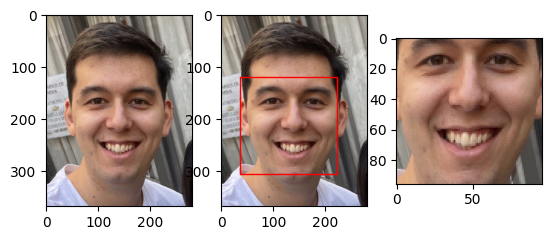

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches


%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[48].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);



In [ ]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img),
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

Verifiquemos en un solo ejemplo de tripleta que la distancia L2 al cuadrado entre su par ancla-positiva es menor que la distancia entre su par ancla-negativa.

### Evaluación del modelo

Este código implementa un proceso de clasificación para un conjunto de datos utilizando dos algoritmos: K-Nearest Neighbors (KNN) y una máquina de vectores de soporte lineal (SVM). Los datos contienen representaciones (embeddings) de imágenes de rostros, con las que se intenta clasificar a las personas basándose en sus identidades.

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score

# Se obtienen los nombres de las identidades de las imágenes en el metadata
targets = np.array([m.name for m in metadata])

# Inicializa el codificador de etiquetas para transformar los nombres en valores numéricos
encoder = LabelEncoder()
encoder.fit(targets)

# Codificación numérica de las identidades
y = encoder.transform(targets)

# Selecciona índices para dividir el dataset en entrenamiento y prueba (pares para prueba, impares para entrenamiento)
train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 ejemplos de entrenamiento y 50 de testeo de 10 identidades (5 ejemplos cada uno)
X_train = embedded[train_idx]
X_test = embedded[test_idx]

# Etiquetas de entrenamiento y prueba
y_train = y[train_idx]
y_test = y[test_idx]

# Inicializa el clasificador KNN con 1 vecino y métrica de distancia euclidiana
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
# Entrena el modelo KNN con los datos de entrenamiento
knn.fit(X_train, y_train)
# Calcula la precisión del modelo KNN en los datos de prueba
acc_knn = accuracy_score(y_test, knn.predict(X_test))

# Inicializa el clasificador SVM con un núcleo lineal
svc = LinearSVC()
# Entrena el modelo SVM con los datos de entrenamiento
svc.fit(X_train, y_train)
# Calcula la precisión del modelo SVM en los datos de prueba
acc_svc = accuracy_score(y_test, svc.predict(X_test))

# Imprime la precisión de ambos clasificadores
print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9310344827586207, SVM accuracy = 0.9310344827586207


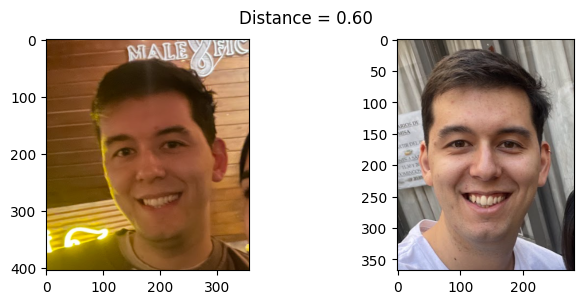

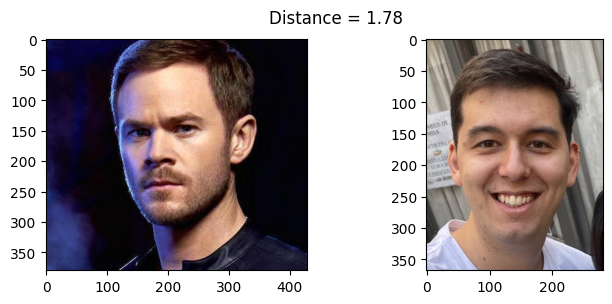

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(49, 48)
show_pair(25, 48)

### Clasificación y Recorte de rostros

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


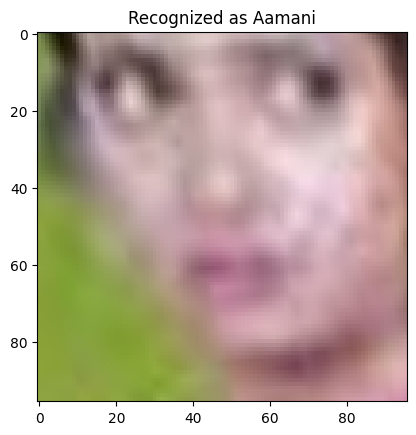

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0138_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


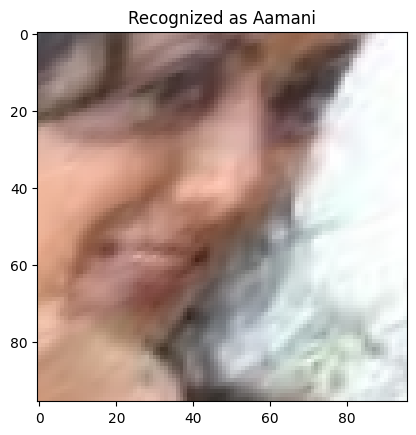

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0147_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


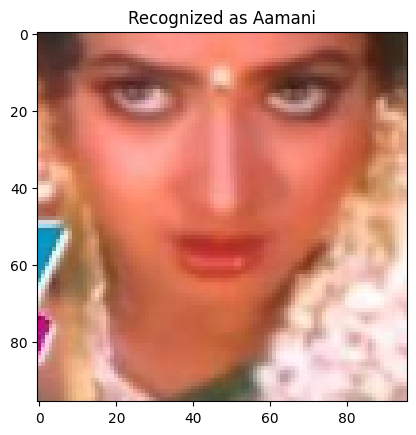

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0150_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


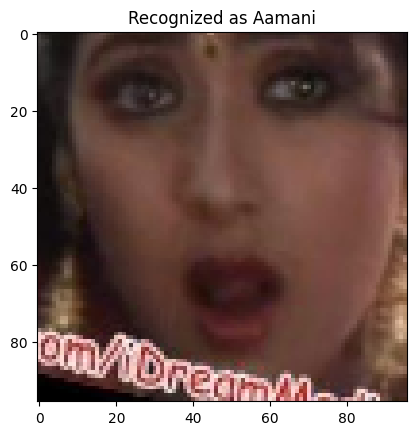

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0154_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


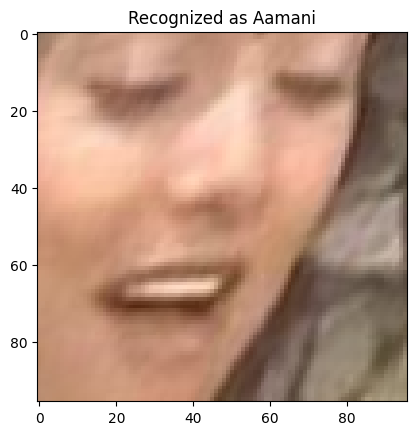

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0155_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


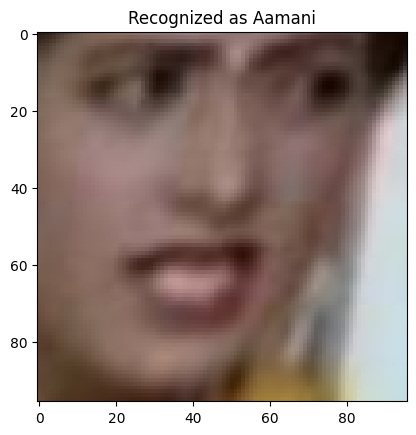

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0157_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


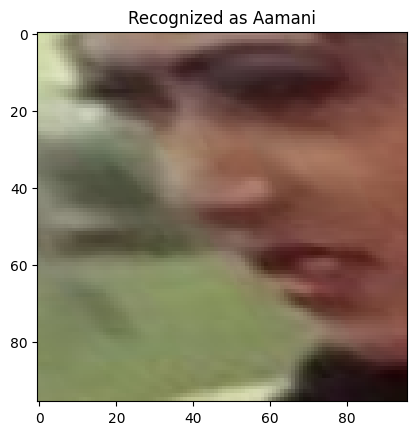

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0158_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


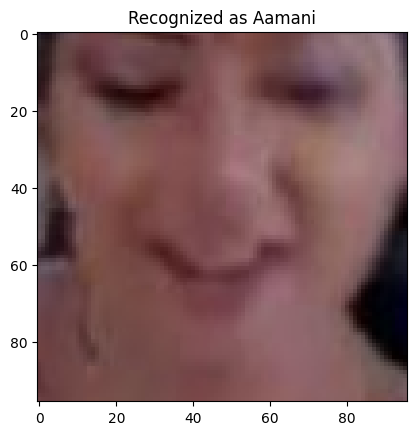

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0166_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


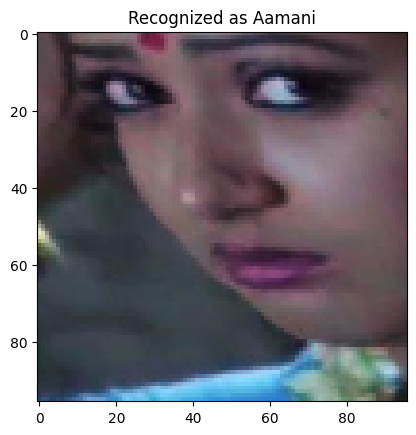

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0167_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


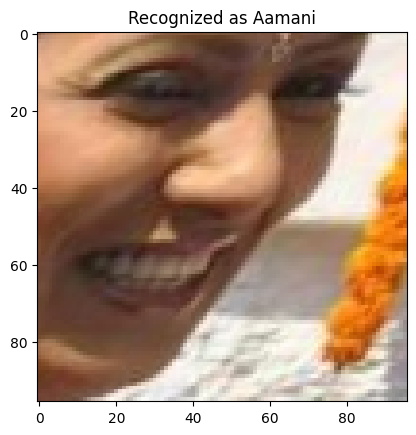

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0169_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


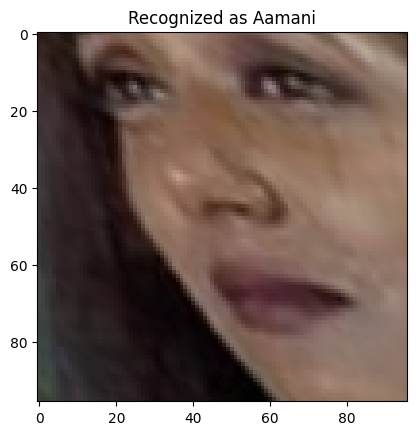

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0176_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


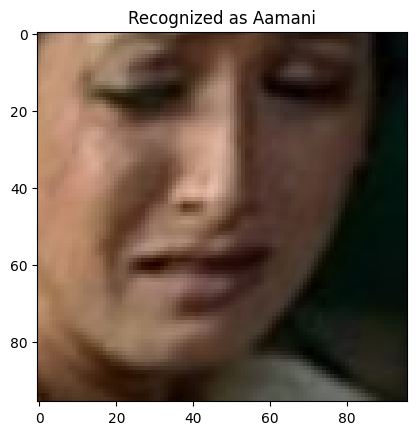

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0199_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


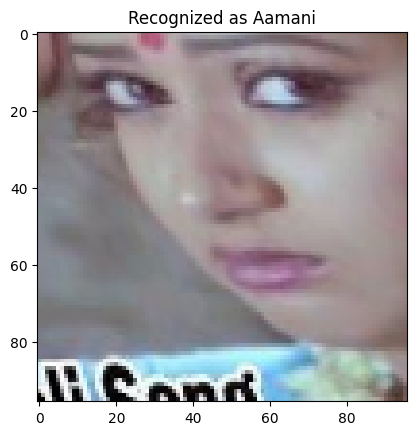

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0214_01.jpg
Failed to align image at /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/FotosCiro/Aamani/Copia de 0220_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


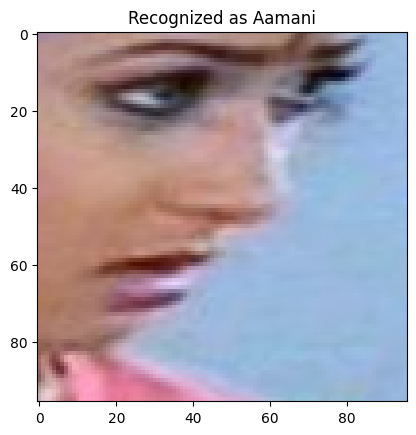

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0223_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


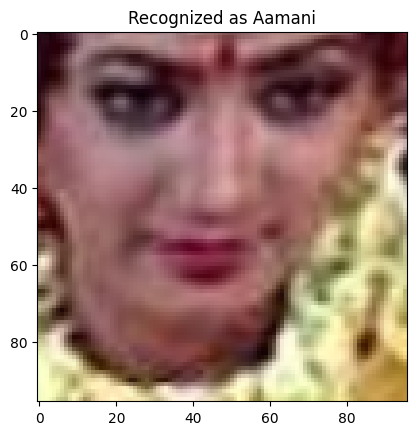

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0240_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


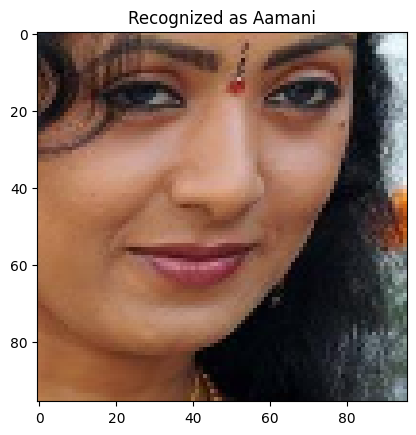

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0272_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


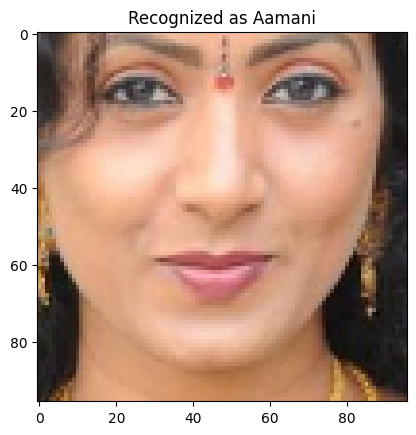

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0273_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


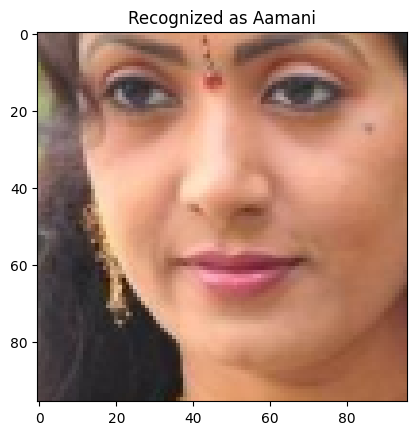

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0275_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


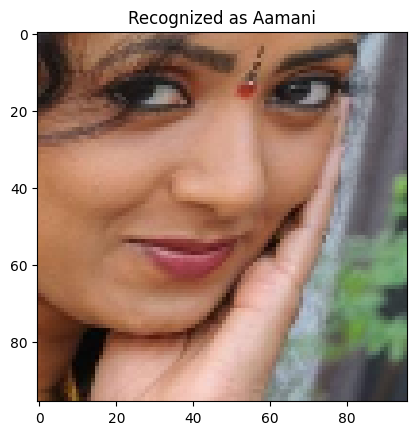

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0276_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


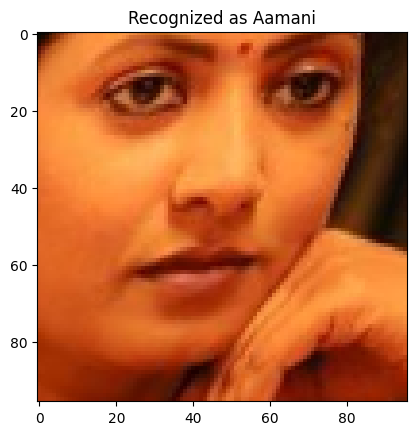

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0280_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


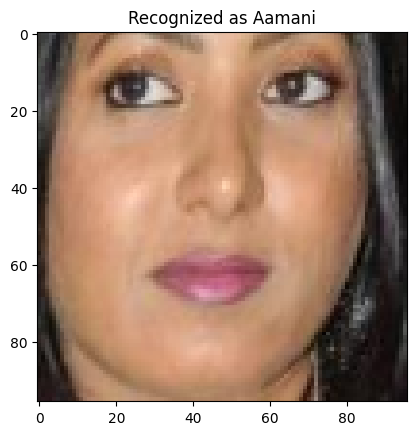

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0284_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


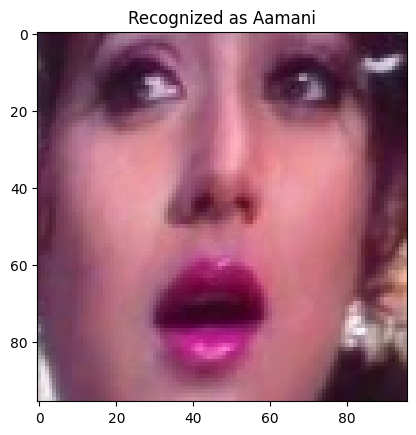

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0290_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


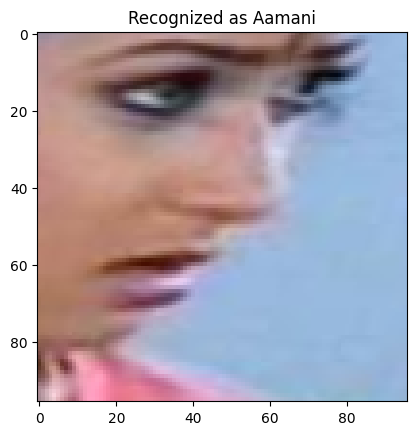

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aamani/Copia de 0297_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


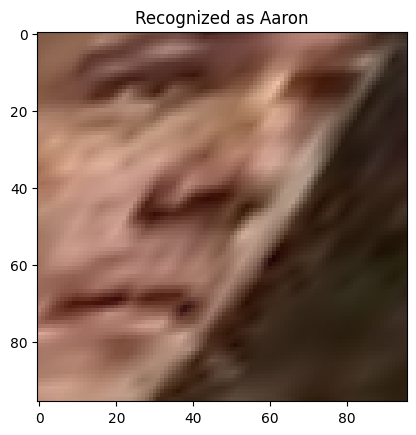

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0396_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


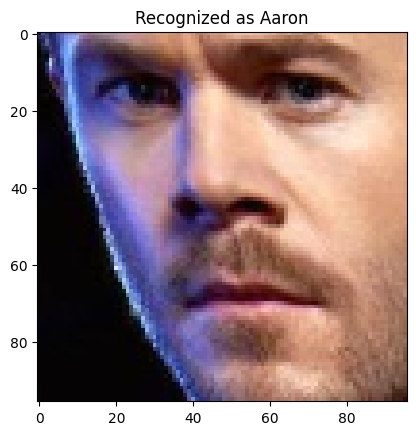

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0397_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


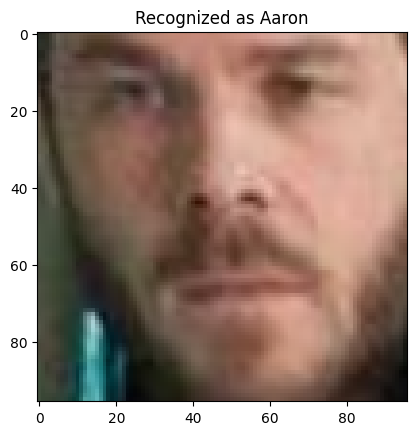

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0399_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


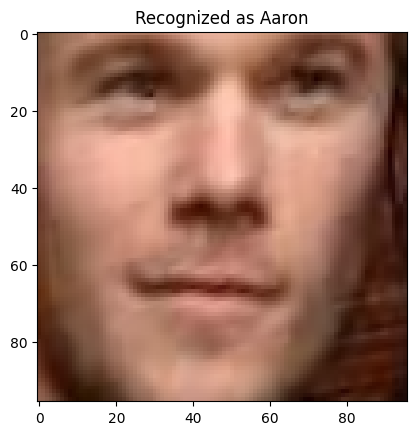

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0400_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


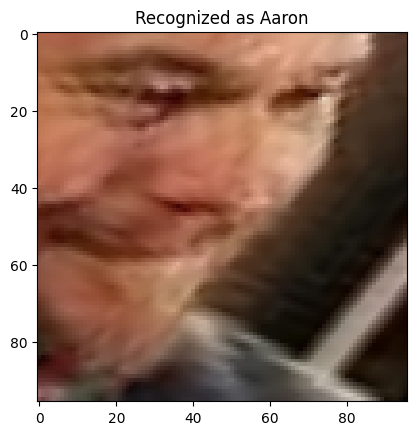

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0401_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


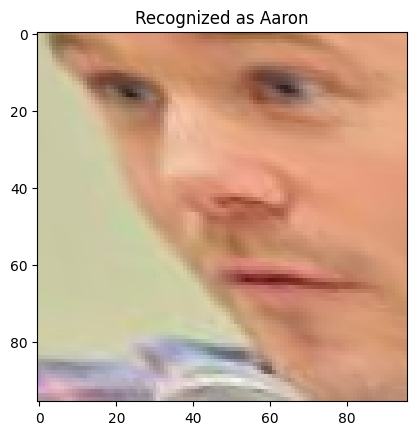

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0402_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


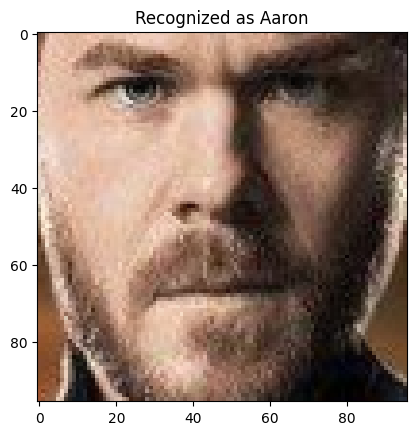

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0403_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


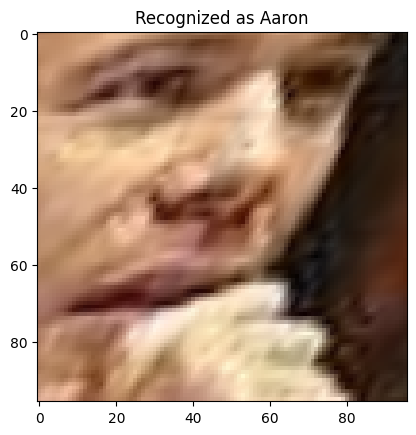

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0404_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


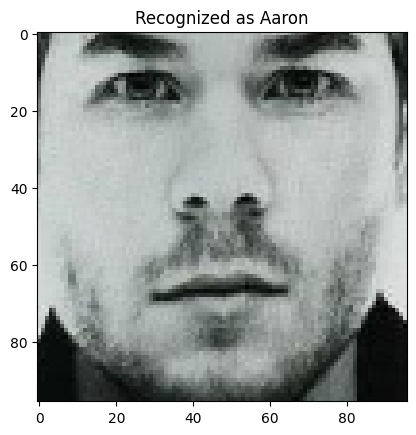

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0406_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


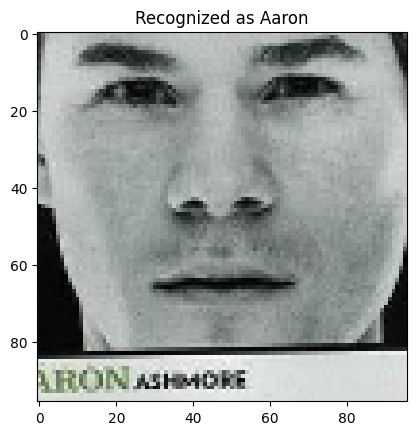

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0406_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


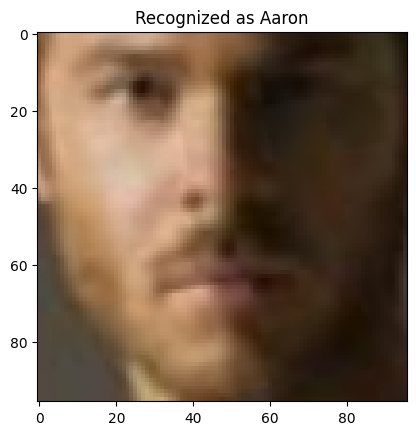

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0408_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


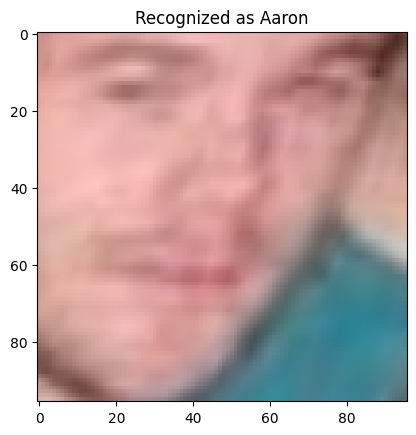

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0410_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


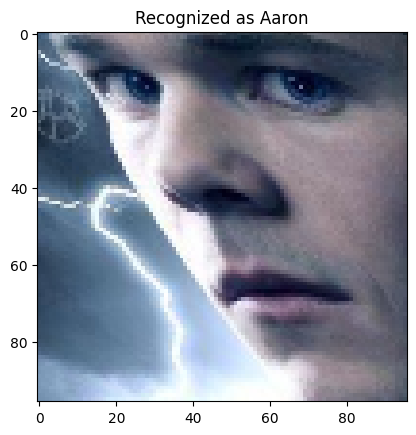

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0412_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


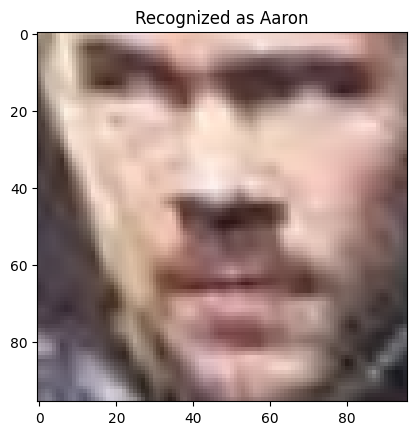

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0414_02.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


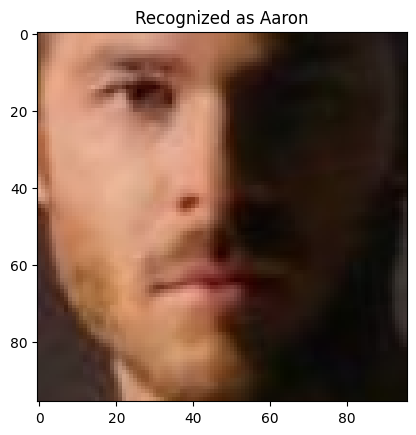

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0415_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


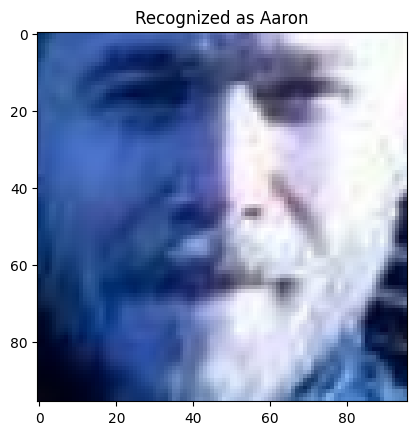

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0417_03.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


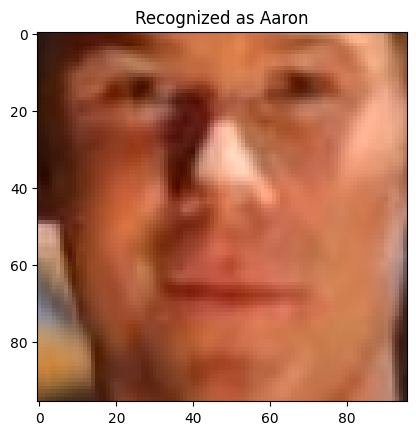

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0419_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


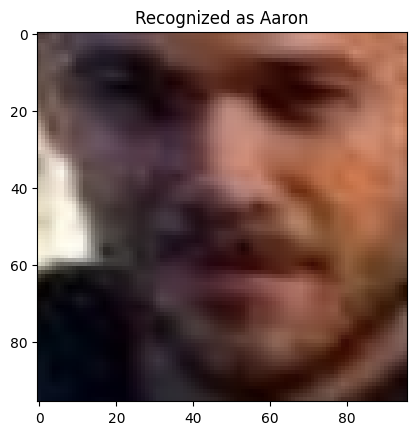

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0420_01.jpg
Failed to align image at /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/FotosCiro/Aaron/Copia de 0422_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


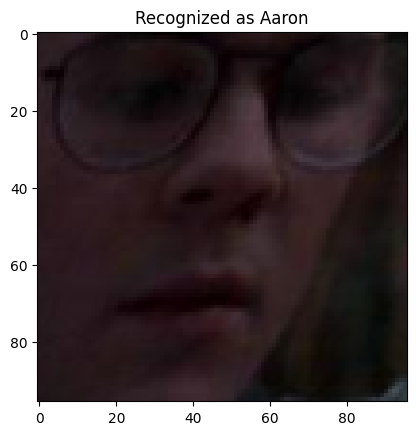

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0425_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


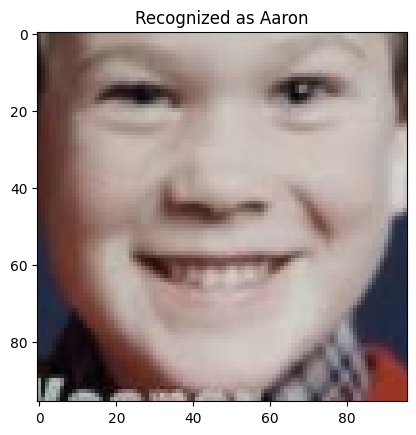

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0426_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


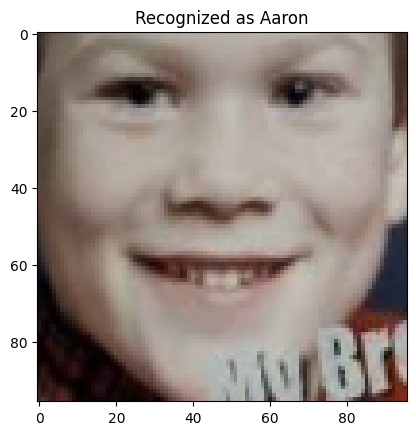

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0426_02.jpg
Failed to align image at /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/FotosCiro/Aaron/Copia de 0427_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


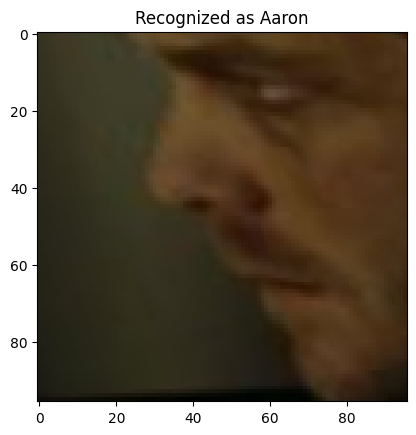

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/Copia de 0430_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


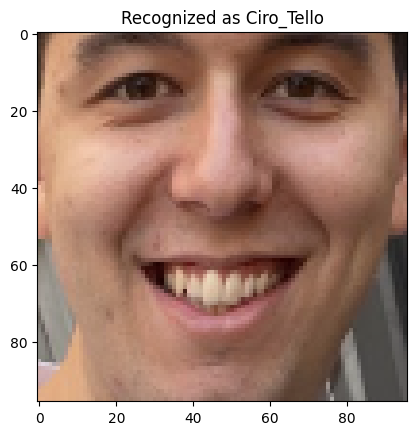

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


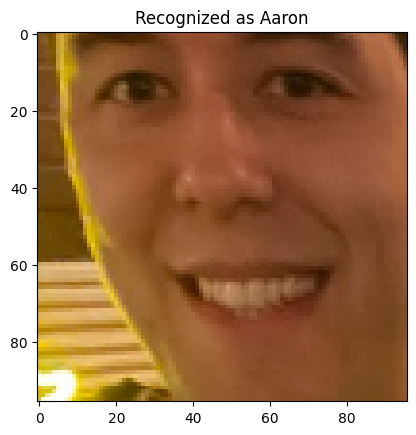

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Aaron/10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


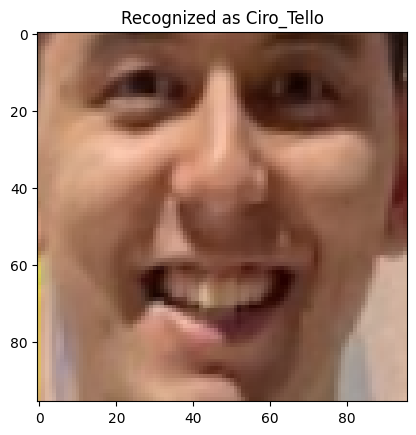

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


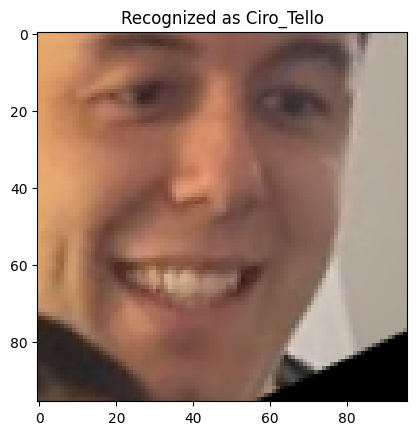

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


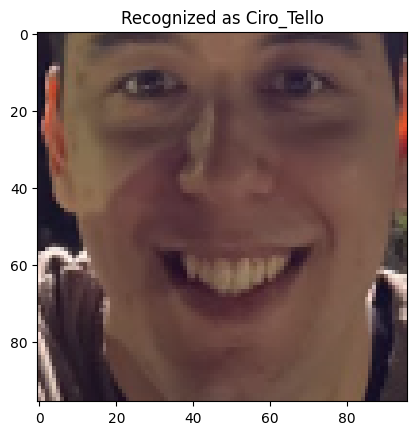

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


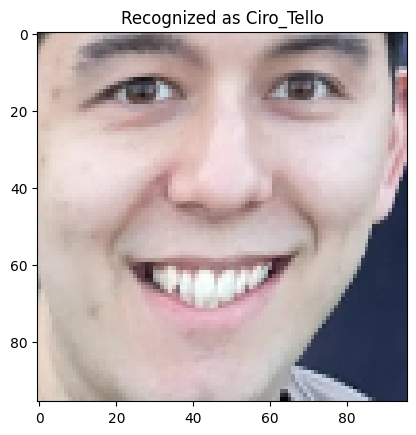

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


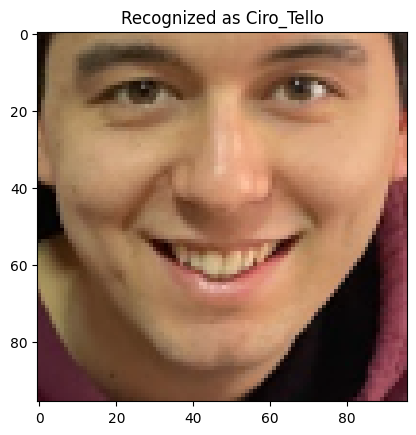

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


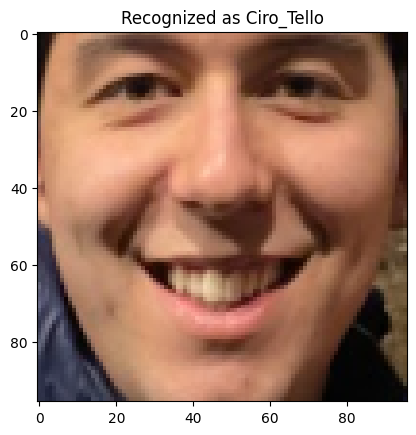

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


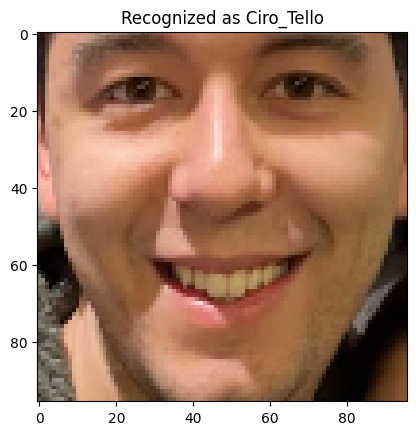

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


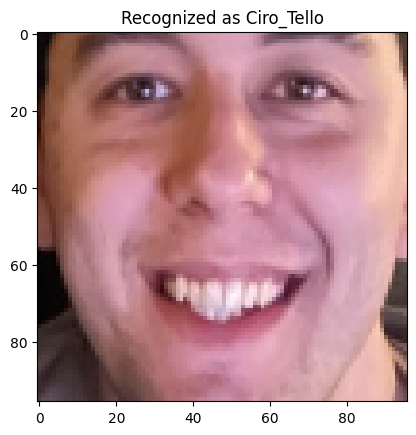

Imagen recortada y clasificada guardada en: /content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro/Ciro_Tello/9.png


In [ ]:
import numpy as np
import os
import warnings
from matplotlib import pyplot as plt
import cv2

# Suprimir advertencias
warnings.filterwarnings('ignore')

# Crear una matriz para almacenar los embeddings
embedded = np.zeros((metadata.shape[0], 128))

# Directorio principal donde se guardarán las imágenes clasificadas
output_dir = '/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_ciro'

# Crear el directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Procesar y clasificar las imágenes
for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    # Alineacion
    if img is None:
        print(f"Failed to load image at {m.image_path()}")
        continue

    img = align_image(img)
    if img is None:
        print(f"Failed to align image at {m.image_path()}")
        continue

    # Normalizar la imagen y calcular el embedding
    img = (img / 255.).astype(np.float32)
    embedded[i] = nn4_small2.predict(np.expand_dims(img, axis=0))[0]

    # Ajustar la forma del embedding para la predicción
    embedding = embedded[i].reshape(1, -1)

    # Realizar la predicción de identidad usando el modelo `svc`
    prediction = svc.predict(embedding)
    identity = encoder.inverse_transform(prediction)[0]

    # Crear carpeta para la identidad si no existe
    identity_dir = os.path.join(output_dir, identity)
    if not os.path.exists(identity_dir):
        os.makedirs(identity_dir)

    # Convertir la imagen de normalizada (0-1) a formato BGR para guardar
    img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    # Guardar la imagen recortada y alineada en la carpeta correspondiente
    output_image_path = os.path.join(identity_dir, f"{os.path.basename(m.image_path())}")
    cv2.imwrite(output_image_path, img_bgr)  # Guardar en formato BGR

    # Mostrar la imagen con la etiqueta predicha
    plt.imshow(img)
    plt.title(f'Recognized as {identity}')
    plt.show()

    print(f"Imagen recortada y clasificada guardada en: {output_image_path}")

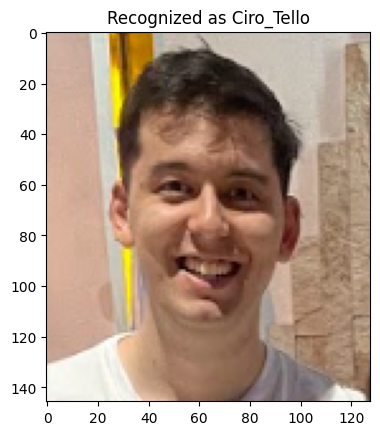

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 25

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

## Etapa II - Carga de datos

###Instalar dependencias

In [ ]:
import os
import gc
from tqdm.notebook import tqdm
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Carga de Datasets y Dataloaders

Se crean dos conjuntos de datos y dataloaders para entrenar el modelo:

- **Dataset Original**: Contiene imágenes sin recortar de celebridades. Este conjunto de datos es útil para evaluar el rendimiento del modelo en su forma original.
- **Dataset Preprocesado**: Contiene imágenes donde se ha recortado la cara de los actores. Este conjunto es importante para concentrarse en las características faciales únicamente.

In [ ]:
image_size = 64
batch_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

# Cargamos el dataset original y el dataset preprocesado con las caras cropeadas
original_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/Dataset - VGGFace2/train', transform=transform)
dataloader_original = DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

preprocessed_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/preprocesed_images', transform=transform)
dataloader_preprocessed = DataLoader(preprocessed_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


###Verificación de dataloaders

A continuación, verificamos que los dataloaders funcionan correctamente mostrando las clases y las imágenes en ambos conjuntos de datos.

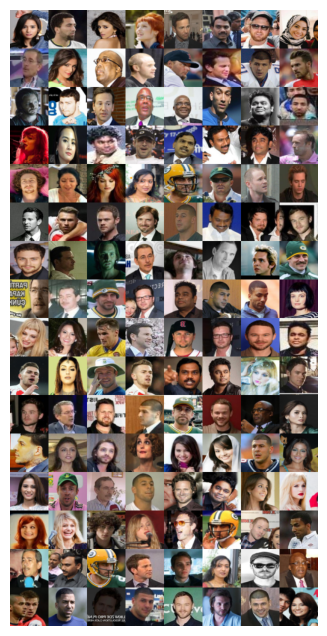

In [ ]:
faces, _ = next(iter(dataloader_original))

grid = torchvision.utils.make_grid(faces, nrow=8, padding=0, scale_each=True)

fig = plt.figure(figsize=(16,8))
plt.imshow(grid.cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

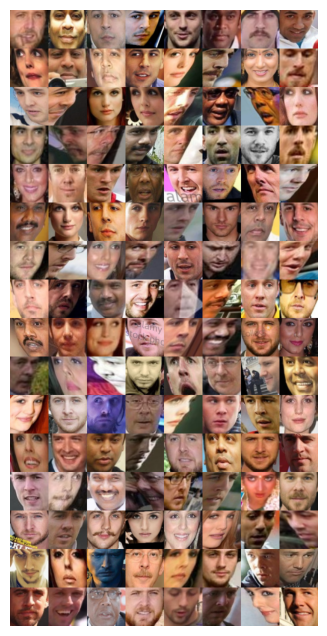

In [ ]:
cropped_faces, _ = next(iter(dataloader_preprocessed))

grid = torchvision.utils.make_grid(cropped_faces, nrow=8, padding=0, scale_each=True)

fig = plt.figure(figsize=(16,8))
plt.imshow(grid.cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

## ETAPA III - Entrenamiento de modelos

####`Decoder`


Esta clase `Decoder` es un de decodificador que toma un vector de características latente `z` y lo transforma en una imagen de salida de dimensiones específicas.

Estructura del Código

 1. Inicialización de parámetros

- `z_dim`: Dimensión del vector latente (512 por defecto), que representa la información comprimida del decodificador.
- `gf_dim`: Dimensión base para los filtros de convolución, que se multiplica para determinar el número de filtros en cada capa.
- `output_size`: Tamaño de la imagen de salida (por defecto 64x64).
- `c_dim`: Número de canales de la imagen de salida (3 por defecto, para imágenes RGB).

2. Capa completamente conectada (Fully connected layer)

- `self.fc`: Es una capa lineal que convierte el vector latente `z` en una matriz de dimensiones adecuadas para las capas de convolución transpuesta posteriores.
- El resultado se redimensiona a `(-1, gf_dim * 8, s8, s8)`, donde `s8` es `output_size // 8`.

3. Capas de convolución transpuesta (Transposed Convolutional Layers)

- Estas capas (`deconv1` a `deconv4`) expanden gradualmente el tamaño espacial de los mapas de características hasta alcanzar el tamaño de la imagen de salida.
- Cada capa tiene activación *ReLU* y, en las primeras tres capas, una normalización de lotes (Batch Normalization) para mejorar la estabilidad del entrenamiento.

4. Activación final

- La última capa (`deconv4`) utiliza activación `tanh`, lo que limita los valores de salida entre -1 y 1, útil para imágenes normalizadas en ese rango.

Método `forward`

En el método `forward`, el flujo de datos a través de la red es el siguiente:

1. El vector latente `z` pasa por la capa `fc`, se transforma con `ReLU` y luego se redimensiona para ajustarse al primer mapa de características de convolución transpuesta.
2. Cada capa de convolución transpuesta expande gradualmente el tamaño espacial y reduce la cantidad de canales.
3. La última capa aplica `tanh` para obtener la imagen de salida, que tiene las dimensiones especificadas (`output_size` x `output_size` x `c_dim`).


In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim=512, gf_dim=64, output_size=64, c_dim=3):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gf_dim = gf_dim
        s8 = output_size // 8

        # Capas densas
        self.fc = nn.Linear(z_dim, gf_dim * 8 * s8 * s8)

        # Capas convolucionales transpuestas
        self.deconv1 = nn.ConvTranspose2d(gf_dim * 8, gf_dim * 4, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn1 = nn.BatchNorm2d(gf_dim * 4)

        self.deconv2 = nn.ConvTranspose2d(gf_dim * 4, gf_dim * 2, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(gf_dim * 2)

        self.deconv3 = nn.ConvTranspose2d(gf_dim * 2, gf_dim // 2, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(gf_dim // 2)

        self.deconv4 = nn.ConvTranspose2d(gf_dim // 2, c_dim, kernel_size=5, stride=1, padding=2)

    def forward(self, z):
        x = F.relu(self.fc(z)).view(-1, self.gf_dim * 8, 8, 8)

        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))

        x = torch.tanh(self.deconv4(x))
        return x

#### `Encoder`



La clase `Encoder` es un codificador que toma una imagen de entrada y la convierte en un vector latente de características `z`.

Estructura del Código

1. Inicialización de parámetros

- `z_dim`: Dimensión del vector latente (512 por defecto).
- `ef_dim`: Dimensión base para los filtros de las capas convolucionales, que se multiplica en cada capa para aumentar el número de filtros.

2. Capas convolucionales

- Las capas `conv1` a `conv4` son convoluciones 2D que extraen características espaciales de la imagen, reduciendo progresivamente el tamaño espacial de los mapas de características mediante el uso de `stride=2`.
- Cada capa convolucional tiene una activación *ReLU* y una normalización de lotes (*Batch Normalization*) para mejorar la estabilidad del entrenamiento.

3. Capas densas

- `fc_mean` y `fc_logvar`: Estas capas lineales son responsables de producir la media (`z_mean`) y la varianza logarítmica (`z_logvar`) del vector latente. Estas variables permiten que el codificador aprenda una distribución latente en lugar de un único valor, útil en los *Variational Autoencoders*.
- `fc_logvar` utiliza una activación `softplus` para garantizar que la varianza sea positiva.

Método `forward`

En el método `forward`, el flujo de datos es el siguiente:

1. La imagen de entrada `x` pasa a través de las capas convolucionales, donde se reduce el tamaño espacial y se aumentan los filtros.
2. El resultado se aplana y se pasa a través de las capas densas `fc_mean` y `fc_logvar`, que producen la media y varianza logarítmica del vector latente.
3. La salida es una tupla `(z_mean, z_logvar)`, que representan la distribución latente de la imagen.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=512, ef_dim=64):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.ef_dim = ef_dim

        # Capas convolucionales
        self.conv1 = nn.Conv2d(3, ef_dim, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(ef_dim)

        self.conv2 = nn.Conv2d(ef_dim, ef_dim * 2, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(ef_dim * 2)

        self.conv3 = nn.Conv2d(ef_dim * 2, ef_dim * 4, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(ef_dim * 4)

        self.conv4 = nn.Conv2d(ef_dim * 4, ef_dim * 8, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(ef_dim * 8)

        # Capas densas
        self.fc_mean = nn.Linear(ef_dim * 8 * 4 * 4, z_dim)
        self.fc_logvar = nn.Linear(ef_dim * 8 * 4 * 4, z_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)

        # Media y desviación estandar
        z_mean = self.fc_mean(x)
        z_logvar = F.softplus(self.fc_logvar(x)) + 1e-6
        return z_mean, z_logvar

#### `VAE`



La clase `VAE` implementa un *Variational Autoencoder*, una arquitectura de red neuronal que mapea datos de entrada (como imágenes) a una representación latente y luego genera datos similares al decodificar desde este espacio latente.

1. Inicialización (`__init__`)

- **`z_dim`**: Dimensión del espacio latente.
- **`ef_dim` y `gf_dim`**: Dimensiones base de los filtros para el *Encoder* y el *Decoder*, respectivamente.
- **`output_size`**: Tamaño de la salida reconstruida (usualmente el tamaño de la imagen original).
- **`c_dim`**: Número de canales de la imagen (3 para RGB).
  
El `VAE` se compone de dos subcomponentes:
- **Encoder**: Convierte la entrada en un vector latente con una media y varianza logarítmica.
- **Decoder**: Reconstruye los datos a partir del vector latente.

2. Método `reparameterize`

El método `reparameterize` permite la generación del vector latente `z` usando la técnica de reparametrización:
- Calcula `std` (desviación estándar) aplicando `torch.exp(0.5 * logvar)`.
- Genera una variable aleatoria `eps` del mismo tamaño que `std`.
- Devuelve el valor `z` usando la fórmula: `mean + eps * std`, lo que permite el flujo de gradientes durante el entrenamiento.

3. Método `forward`

En el método `forward`, el flujo es el siguiente:

1. La entrada `x` pasa al `encoder`, produciendo la media (`mean`) y varianza logarítmica (`logvar`) de la distribución latente.
2. Usa `reparameterize` para obtener el vector `z` en el espacio latente.
3. El vector `z` pasa al `decoder` para reconstruir la entrada, generando `x_reconstructed`.
4. El método devuelve una tupla `(x_reconstructed, mean, logvar)`.

In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dim=512, ef_dim=64, gf_dim=64, output_size=64, c_dim=3):
        super(VAE, self).__init__()
        self.encoder = Encoder(z_dim, ef_dim)
        self.decoder = Decoder(z_dim, gf_dim, output_size, c_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mean, logvar

In [ ]:
model = VAE().to(device)

In [ ]:
model(
    torch.randn(2, 3, image_size, image_size).to(device)
)[0].shape

torch.Size([2, 3, 64, 64])

In [ ]:
summary(model, (3, image_size, image_size), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 16, 16]         204,928
       BatchNorm2d-4          [-1, 128, 16, 16]             256
            Conv2d-5            [-1, 256, 8, 8]         819,456
       BatchNorm2d-6            [-1, 256, 8, 8]             512
            Conv2d-7            [-1, 512, 4, 4]       3,277,312
       BatchNorm2d-8            [-1, 512, 4, 4]           1,024
            Linear-9                  [-1, 512]       4,194,816
           Linear-10                  [-1, 512]       4,194,816
          Encoder-11     [[-1, 512], [-1, 512]]               0
           Linear-12                [-1, 32768]      16,809,984
  ConvTranspose2d-13          [-1, 256, 16, 16]       3,277,056
      BatchNorm2d-14          [-1, 256,

#### Entrenamiento

La funcion `train_vae` entrena un modelo *Variational Autoencoder* (VAE) utilizando PyTorch. Incluye la configuración de la función de pérdida, la optimización, y el guardado del modelo.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Método de entrenamiento
def train_vae(model, data_loader, epochs=30, learning_rate=0.001, beta=0.005, checkpoint_path='/content/drive/MyDrive/new_vae_weights.pth'):
    # Configuración del optimizador
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Definición de las funciones de pérdida
    mse_loss = nn.MSELoss(reduction='sum')

    # Entrenamiento del modelo
    model.train()
    training_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        total_epoch_loss = 0

        # Iteramos sobre el dataset
        for idx, (batch_images, _) in enumerate(data_loader):
            # Pasa los datos al dispositivo
            batch_images = batch_images.to(device)

            # Forward: reconstrucción y cálculo de mu y log_var
            recon_batch, mu, log_var = model(batch_images)

            # Pérdidas: reconstrucción (MSE) y KL divergence
            sse_loss = mse_loss(recon_batch, batch_images)
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Pérdida total con beta-weighting para KL divergence
            vae_loss = sse_loss + beta * kl_loss

            # Acumula la pérdida total para esta epoch
            total_epoch_loss += vae_loss.item()

            # Backpropagation y optimización
            optimizer.zero_grad()
            vae_loss.backward()
            optimizer.step()

        average_epoch_loss = total_epoch_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {average_epoch_loss:.4f} - Tiempo: {(time.time() - epoch_start_time) / 60:.2f} mins")

    print(f"Entrenamiento completo en {(time.time() - training_start_time) / 60:.2f} mins")

    # Guardar el modelo entrenado
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Modelo guardado en {checkpoint_path}")

Dataloader original

In [ ]:
train_vae(model, dataloader_original, epochs=200, learning_rate=0.001, beta=0.005,  checkpoint_path='/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/weights/original_weights.pth')

Epoch 1/200 - Loss: 87917151080370.5156 - Tiempo: 10.40 mins
Epoch 2/200 - Loss: 138734.0994 - Tiempo: 0.48 mins
Epoch 3/200 - Loss: 119040.5692 - Tiempo: 0.48 mins
Epoch 4/200 - Loss: 102362.9402 - Tiempo: 0.47 mins
Epoch 5/200 - Loss: 88996.5536 - Tiempo: 0.46 mins
Epoch 6/200 - Loss: 77790.6640 - Tiempo: 0.47 mins
Epoch 7/200 - Loss: 73446.8354 - Tiempo: 0.48 mins
Epoch 8/200 - Loss: 66231.3424 - Tiempo: 0.47 mins
Epoch 9/200 - Loss: 63713.1630 - Tiempo: 0.46 mins
Epoch 10/200 - Loss: 62677.4297 - Tiempo: 0.50 mins
Epoch 11/200 - Loss: 59478.0126 - Tiempo: 0.47 mins
Epoch 12/200 - Loss: 57335.9014 - Tiempo: 0.48 mins
Epoch 13/200 - Loss: 53716.4549 - Tiempo: 0.47 mins
Epoch 14/200 - Loss: 51768.7782 - Tiempo: 0.48 mins
Epoch 15/200 - Loss: 51574.3697 - Tiempo: 0.48 mins
Epoch 16/200 - Loss: 49896.4872 - Tiempo: 0.48 mins
Epoch 17/200 - Loss: 47771.0855 - Tiempo: 0.49 mins
Epoch 18/200 - Loss: 46572.2065 - Tiempo: 0.48 mins
Epoch 19/200 - Loss: 46110.3909 - Tiempo: 0.49 mins
Epoch 20

Dataloader preprocesado

In [ ]:
train_vae(model, dataloader_preprocessed, epochs=200, learning_rate=0.001, beta=0.005,  checkpoint_path='/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/weights/preprocessed_weights.pth')

Epoch 1/200 - Loss: 42797.2415 - Tiempo: 8.15 mins
Epoch 2/200 - Loss: 21197.4232 - Tiempo: 0.30 mins
Epoch 3/200 - Loss: 17705.2296 - Tiempo: 0.32 mins
Epoch 4/200 - Loss: 16034.9654 - Tiempo: 0.30 mins
Epoch 5/200 - Loss: 15125.6311 - Tiempo: 0.31 mins
Epoch 6/200 - Loss: 14095.2015 - Tiempo: 0.31 mins
Epoch 7/200 - Loss: 13632.1558 - Tiempo: 0.30 mins
Epoch 8/200 - Loss: 12914.4673 - Tiempo: 0.31 mins
Epoch 9/200 - Loss: 12602.7408 - Tiempo: 0.31 mins
Epoch 10/200 - Loss: 12076.8940 - Tiempo: 0.30 mins
Epoch 11/200 - Loss: 12071.1881 - Tiempo: 0.30 mins
Epoch 12/200 - Loss: 11530.3029 - Tiempo: 0.31 mins
Epoch 13/200 - Loss: 10833.8528 - Tiempo: 0.31 mins
Epoch 14/200 - Loss: 10775.2195 - Tiempo: 0.30 mins
Epoch 15/200 - Loss: 10570.0967 - Tiempo: 0.31 mins
Epoch 16/200 - Loss: 10112.6063 - Tiempo: 0.30 mins
Epoch 17/200 - Loss: 9767.5270 - Tiempo: 0.29 mins
Epoch 18/200 - Loss: 9476.0635 - Tiempo: 0.31 mins
Epoch 19/200 - Loss: 9290.8661 - Tiempo: 0.31 mins
Epoch 20/200 - Loss: 924

#### Cargamos el modelo

In [ ]:
def load_model(model, checkpoint_path='/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/weights/preprocessed_weights.pth'):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [ ]:
original_model = load_model(model, checkpoint_path='/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/weights/original_weights.pth')
preprocessed_model = load_model(model, checkpoint_path='/content/drive/MyDrive/Trabajo Integrador Redes Neuronales/weights/preprocessed_weights.pth')

<ipython-input-10-d24bc378bb3b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


### Inferencias


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


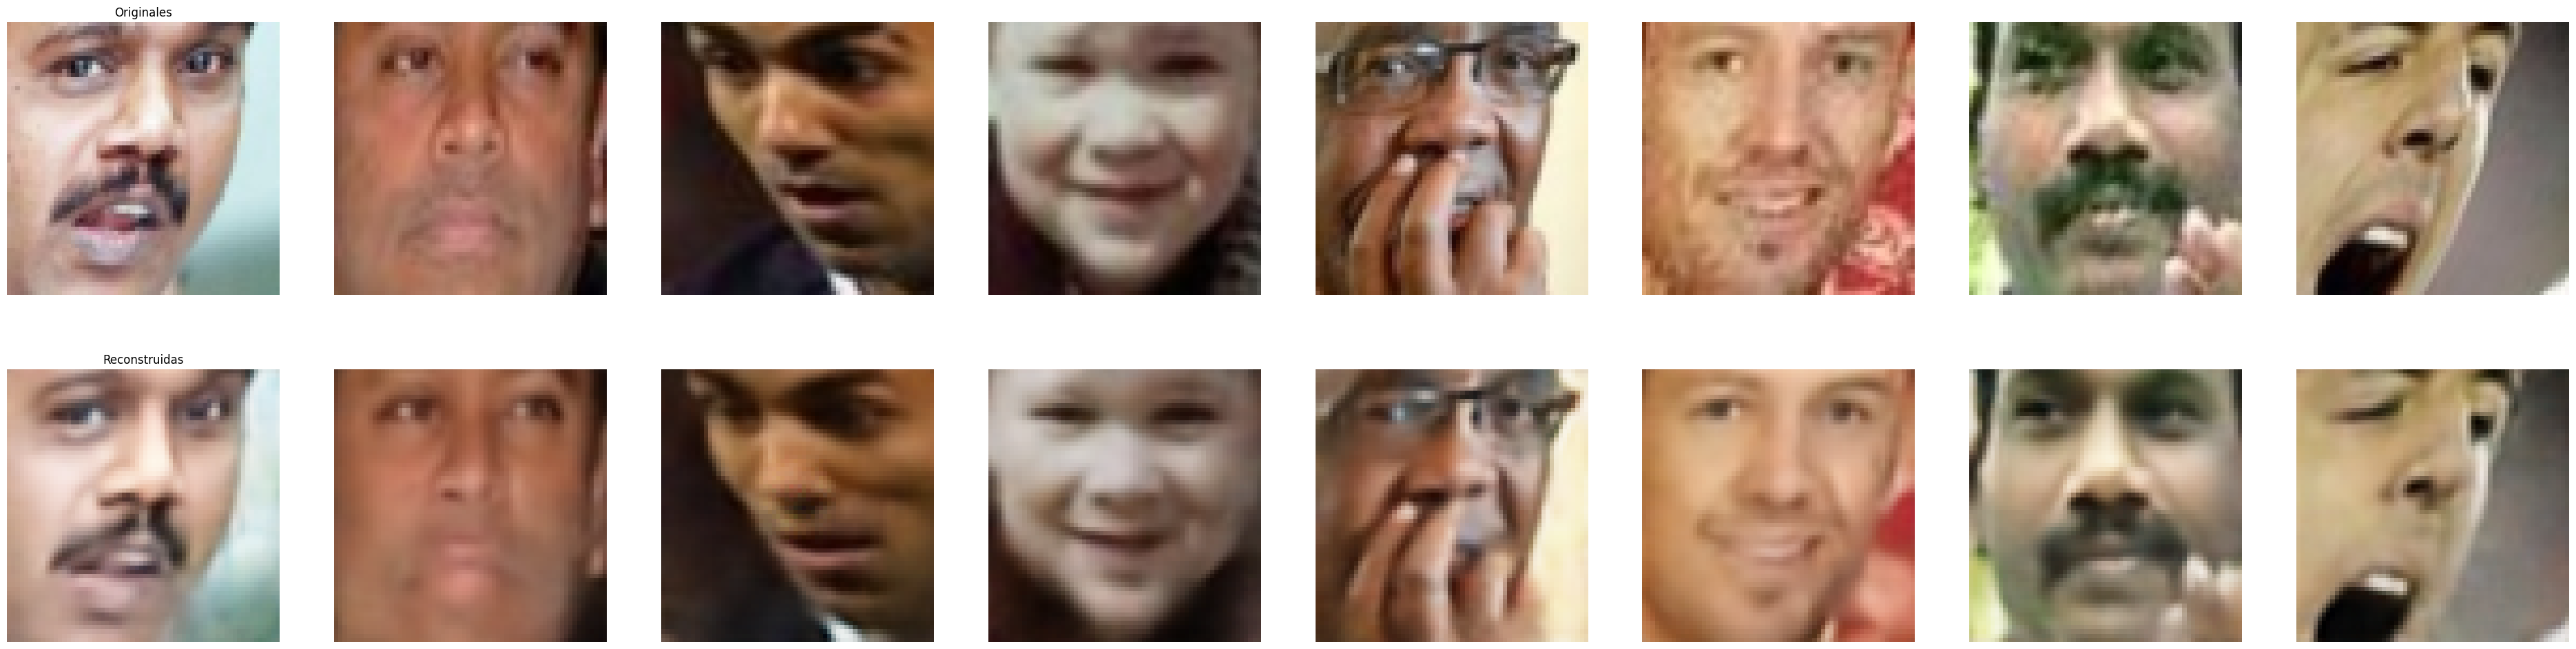

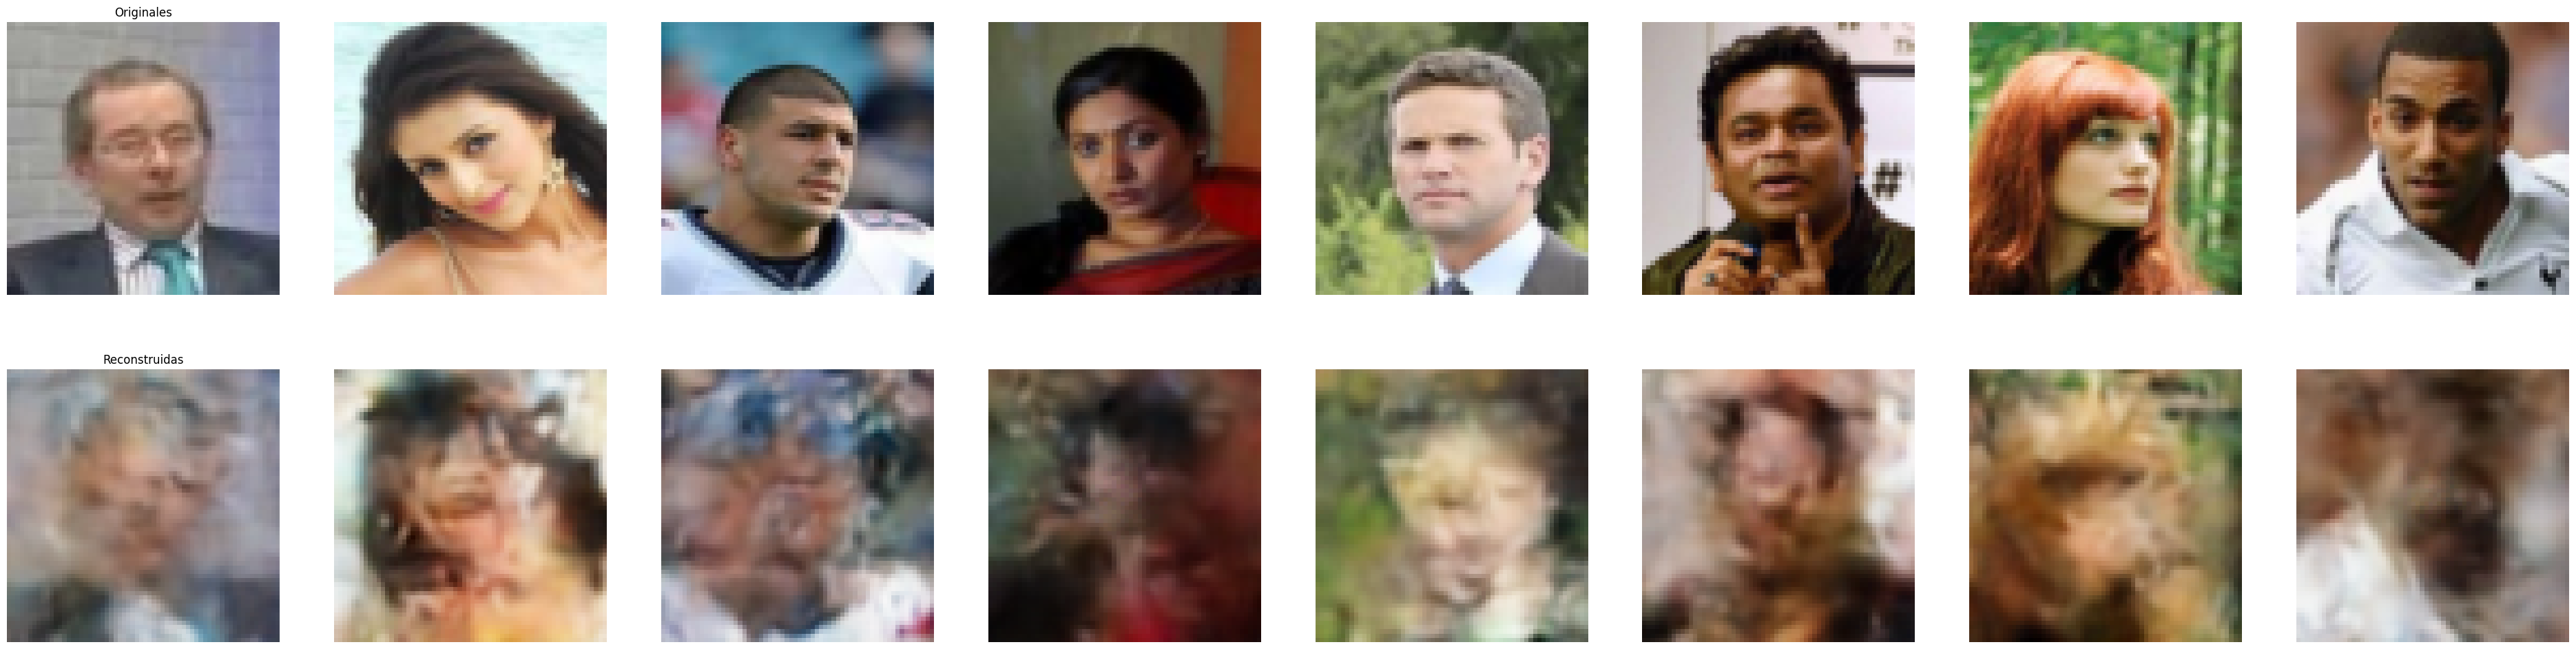

In [ ]:
def infer_and_show_images(dataloader, model, device, num_images=8, image_scale=4):
    model.eval()

    with torch.no_grad():
        images, _ = next(iter(dataloader))
        images = images.to(device)

        # Generar inferencia
        reconstructed_images, _, _ = model(images)

        # Mover los tensores a CPU para visualización
        images = images.cpu()
        reconstructed_images = reconstructed_images.cpu()

        # Visualizar las imágenes originales y reconstruidas con mayor tamaño
        fig, axes = plt.subplots(2, num_images, figsize=(num_images * image_scale, image_scale * 2))

        # Mostrar imágenes originales
        for i in range(num_images):
            axes[0, i].imshow(images[i].permute(1, 2, 0))
            axes[0, i].axis('off')
        axes[0, 0].set_title("Originales")

        # Mostrar imágenes reconstruidas
        for i in range(num_images):
            axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0))
            axes[1, i].axis('off')
        axes[1, 0].set_title("Reconstruidas")

        plt.show()

# Ejecutar inferencias y mostrar resultados con mayor tamaño de imagen
infer_and_show_images(dataloader_preprocessed, preprocessed_model, device=device, image_scale=6)
infer_and_show_images(dataloader_original, original_model, device=device, image_scale=6)


Podemos ver que claramente el modelo entrenado con las imagenes preprocesadas es mucho mejor por lo que seleccionamos este modelo para hacer las inferencias y graficar el espacio latente

Interpolación

In [ ]:
import numpy as np

def get_interp(v1, v2, n):
  if not v1.shape == v2.shape:
    raise Exception('Diferent vector size')

  v1 = v1.to("cpu")
  v2 = v2.to("cpu")

  return np.array([np.linspace(v1[i], v2[i], n+2) for i in range(v1.shape[0])]).T

def model_interp(model, index1, index2, size = 10):
  img1 = preprocessed_dataset[index1][0].to(device).unsqueeze(0)
  img2 = preprocessed_dataset[index2][0].to(device).unsqueeze(0)

  with torch.no_grad():
    img1_compressed = model.encoder(img1)[0]
    img2_compressed = model.encoder(img2)[0]
    interps = get_interp(img1_compressed, img2_compressed, size)

    interps = torch.tensor(interps).to(device).squeeze()
    interps = interps.permute(1, 0)

    decoded_interps = model.decoder(interps)

  return decoded_interps

def show_interp(imgs, index1, index2, titles=None, scale=1.5):
  figsize = (12 * scale, 1 * scale)
  _, axes = plt.subplots(1, 12, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    try:
      img = img.detach().numpy()
    except:
      pass
    if i==0:
      ax.set_title(titles[0])
      ax.imshow(preprocessed_dataset[index1][0].permute(1,2,0).cpu().detach().numpy())
    elif i==11:
      ax.set_title(titles[1])
      ax.imshow(preprocessed_dataset[index2][0].permute(1,2,0).cpu().detach().numpy())
    else:
      ax.imshow(img)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
  return axes

array([<Axes: title={'center': '1'}>, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: title={'center': '2'}>], dtype=object)

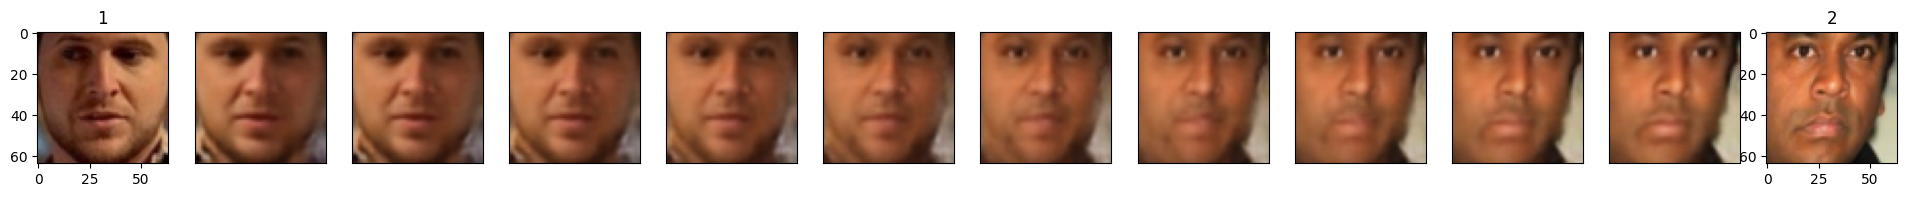

In [ ]:
index1 = 300
index2 = 560
interp_result = model_interp(model=preprocessed_model, index1=index1, index2=index2).unbind(0)
imgs = [img.permute(1, 2, 0).cpu() for img in interp_result]
show_interp(imgs, index1, index2, scale=2,  titles=['1', '2'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


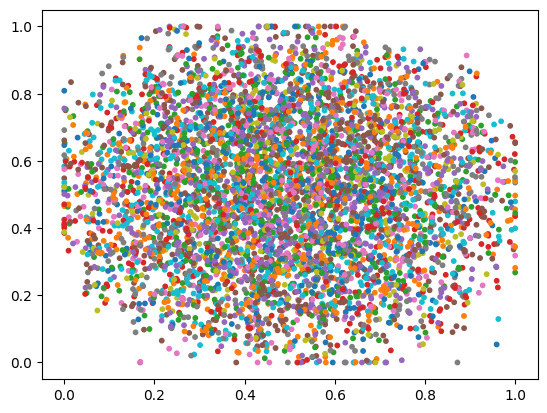

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import psutil
import numpy as np

# Tamaño del batch reducido para evitar sobrecargar la memoria
batch_size = 500  # Puedes ajustar este valor según tu memoria disponible
data_list = []
labels_list = []

# Listas para almacenar los resultados de TSNE y las etiquetas
z_2D_list = []
labels_data_list = []

# Itera sobre el DataLoader para obtener los datos
for inputs, labels in dataloader_preprocessed:
    data_list.append(inputs)
    labels_list.append(labels)

    # Si hemos acumulado suficientes datos, procesamos un lote
    if len(data_list) * batch_size >= batch_size:
        # Concatenamos los lotes actuales
        input_data = torch.cat(data_list, dim=0)  # Concatenar todos los lotes
        labels_data = torch.cat(labels_list, dim=0)

        # Pasa los datos por el encoder para obtener la salida
        output = preprocessed_model.encoder(input_data.to(device))

        # Si la salida es una tupla, asignamos el primer valor (que normalmente es el espacio latente)
        z = output[0]

        # Si el espacio latente tiene 2 dimensiones, lo usamos directamente
        if z.shape[1] == 2:
            z_2D = z
        else:
            tsne = TSNE()
            z_2D = tsne.fit_transform(z.detach().cpu().numpy())
            z_2D = (z_2D - z_2D.min()) / (z_2D.max() - z_2D.min())  # Normaliza el resultado

        # Almacena los resultados de TSNE y las etiquetas para graficar todo al final
        z_2D_list.append(z_2D)
        labels_data_list.append(labels_data.numpy())

        # Limpiamos las listas para liberar memoria
        data_list.clear()
        labels_list.clear()

        # Liberar memoria después de cada lote
        del input_data
        del labels_data
        torch.cuda.empty_cache()  # Si estás usando CUDA

# Si hay datos restantes que no se procesaron, procesarlos también
if len(data_list) > 0:
    input_data = torch.cat(data_list, dim=0)
    labels_data = torch.cat(labels_list, dim=0)

    output = preprocessed_model.encoder(input_data.to(device))
    z = output[0]

    if z.shape[1] == 2:
        z_2D = z
    else:
        tsne = TSNE()
        z_2D = tsne.fit_transform(z.detach().cpu().numpy())
        z_2D = (z_2D - z_2D.min()) / (z_2D.max() - z_2D.min())  # Normaliza el resultado

    labels_data = labels_data.numpy()

    z_2D_list.append(z_2D)
    labels_data_list.append(labels_data)

    del input_data
    del labels_data
    torch.cuda.empty_cache()  # Si estás usando CUDA

# Al final, concatena todas las partes de z_2D y etiquetas
z_2D_all = np.concatenate(z_2D_list, axis=0)
labels_data_all = np.concatenate(labels_data_list, axis=0)

# Muestra el gráfico con todos los datos
plt.scatter(z_2D_all[:, 0], z_2D_all[:, 1], c=labels_data_all, s=10, cmap="tab10")
plt.show()
